### Initialization

In [1]:
import pandas as pd
import spacy
from collections import Counter, defaultdict
import time
from tools import *
import pandas as pd
import spacy

# Load English model of spaCy
nlp = spacy.load("en_core_web_sm")

# Load dataset
start_time = time.time()
data = pd.read_csv("Raw_Reviews.csv")

# Sample to debug
sample = False # True / False

if sample:
    data = data.sample(n=1000, replace=False, random_state=4)

print(f"Time taken to load dataset: {time.time() - start_time:.2f} seconds")
display(data)

Time taken to load dataset: 0.09 seconds


,Product_ID,Age,Title,Text_Review,Rating,Type
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,Intimate
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,Bottoms
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,Tops
...,...,...,...,...,...,...
23481,1104,34,Great dress for many occasions,I was very happy to snag this dress at such a ...,5,Dresses
23482,862,48,Wish it was made of cotton,"It reminds me of maternity clothes. soft, stre...",3,Tops
23483,1104,31,"Cute, but see through","This fit well, but the top was very see throug...",3,Dresses
23484,1084,28,"Very cute dress, perfect for summer parties an...",I bought this dress for a wedding i have this ...,3,Dresses


### Data Exploration

In [2]:
# Display basic information about the dataset
print("Dataset Information:")
print(data.info())

# Display the number of missing values in each column
print("\nNumber of Missing Values in Each Column:")
print(data.isnull().sum())

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Product_ID   23486 non-null  int64 
 1   Age          23486 non-null  int64 
 2   Title        19676 non-null  object
 3   Text_Review  22641 non-null  object
 4   Rating       23486 non-null  int64 
 5   Type         23472 non-null  object
dtypes: int64(3), object(3)
memory usage: 1.1+ MB
None

Number of Missing Values in Each Column:
Product_ID        0
Age               0
Title          3810
Text_Review     845
Rating            0
Type             14
dtype: int64


In [3]:
# Display unique values for categorical columns
categorical_columns = ["Product_ID", "Age", "Rating","Type"]
for col in categorical_columns:
    print(f"\nUnique values for {col}:")
    print(data[col].unique())


Unique values for Product_ID:
[ 767 1080 1077 ...  181  721  522]

Unique values for Age:
[33 34 60 50 47 49 39 24 53 44 41 32 55 31 28 46 21 36 65 29 38 59 40 23
 67 48 43 52 56 66 61 57 58 37 27 62 68 51 83 69 54 63 71 30 35 64 42 22
 26 72 25 45 74 70 20 80 93 82 77 85 73 78 79 19 76 84 75 89 81 90 94 86
 99 18 91 87 92]

Unique values for Rating:
[4 5 3 2 1]

Unique values for Type:
['Intimate' 'Dresses' 'Bottoms' 'Tops' 'Jackets' 'Trend' nan]


In [4]:
# Display the distribution of ratings
print("\nDistribution of Ratings:")
print(data["Rating"].value_counts())

# Display the distribution of product types
print("\nDistribution of Product Types:")
print(data["Type"].value_counts())


Distribution of Ratings:
Rating
5    13131
4     5077
3     2871
2     1565
1      842
Name: count, dtype: int64

Distribution of Product Types:
Type
Tops        10468
Dresses      6319
Bottoms      3799
Intimate     1735
Jackets      1032
Trend         119
Name: count, dtype: int64


### Data Preprocessing:


In [5]:
# Convert to string
data["Product_ID"] = data["Product_ID"].astype(str)
data["Title"] = data["Title"].astype(str)
data["Text_Review"] = data["Text_Review"].astype(str)
data["Type"] = data["Type"].astype(str)

# Convert to int
data["Age"] = data["Age"].astype(int)
data["Rating"] = data["Rating"].astype(int)

# Clean up Title and Text_Review columns
data["Title"] = data["Title"].str.strip()
data["Text_Review"] = data["Text_Review"].str.strip()
data["Product_ID"] = data["Product_ID"].str.strip()

# Ensure consistency (convert to lowercase)
data["Product_ID"] = data["Product_ID"].str.lower()
data["Title"] = data["Title"].str.lower()
data["Text_Review"] = data["Text_Review"].str.lower()
data["Type"] = data["Type"].str.lower()

# Print first few rows
data.head()


,Product_ID,Age,Title,Text_Review,Rating,Type
0,767,33,nan,absolutely wonderful - silky and sexy and comf...,4,intimate
1,1080,34,nan,love this dress! it's sooo pretty. i happene...,5,dresses
2,1077,60,some major design flaws,i had such high hopes for this dress and reall...,3,dresses
3,1049,50,my favorite buy!,"i love, love, love this jumpsuit. it's fun, fl...",5,bottoms
4,847,47,flattering shirt,this shirt is very flattering to all due to th...,5,tops


In [6]:
data.describe()

,Age,Rating
count,23486.000000,23486.000000
mean,43.198544,4.196032
std,12.279544,1.110031
min,18.000000,1.000000
25%,34.000000,4.000000
50%,41.000000,5.000000
75%,52.000000,5.000000
max,99.000000,5.000000


### Customer Age Distribution and Ratings Insights

#### Customer Age Distribution
- **Age Range**: The age of customers ranges from 18 to 99 years, indicating that the store serves a very broad demographic from young adults to seniors.
- **Mean Age**: The average age of customers is approximately 43 years, suggesting a more mature audience.
- **Age Quartiles**:
  - **25th Percentile**: 34 years — 25% of the customers are younger than 34.
  - **Median Age (50th Percentile)**: half of the customers are under 41 years old.
  - **75th Percentile**: 52 years — 75% of the customers are younger than 52, meaning significant portion of the customer base is in their 30s, 40s, and early 50s.

#### Customer Ratings
- **Rating Scale**: Ratings range from 1 to 5, with 5 being the highest.
- **Mean Rating**: The average rating is approximately 4.2, suggesting a generally positive customer satisfaction.
- **Rating Distribution**:
  - The minimum rating is 1, indicating some customer dissatisfaction.
  - The 25th percentile is at or above 4, while the median (50th percentile) and the 75th percentile are both at 5. This indicates that a significant number of customers give the highest possible rating, suggesting a generally positive customer response.


### Feature Engineering

In [7]:
start_time = time.time()
negative_adjectives_df, positive_adjectives_df = identify_adjectives(data)

# Calculate sum and mean grouped by 'Type'
grouped_pos_data = positive_adjectives_df.groupby('Type')['Count'].agg(['sum', 'mean']).reset_index()
grouped_neg_data = negative_adjectives_df.groupby('Type')['Count'].agg(['sum', 'mean']).reset_index()

print("Positive Adjectives by Type:")
display(grouped_pos_data)
print("Negative Adjectives by Type:")
display(grouped_neg_data)

# Calculate the elapsed time
fe_time = time.time() - start_time
print(f"Parsing Adjectives Time: {fe_time:.2f} seconds")

Positive Adjectives by Type:


,Type,sum,mean
0,bottoms,24160,2.495352
1,dresses,41485,4.379289
2,intimate,10369,1.261436
3,jackets,7088,2.072515
4,nan,65,1.226415
5,tops,65528,3.555122
6,trend,836,1.222222


Negative Adjectives by Type:


,Type,sum,mean
0,bottoms,298,1.155039
1,dresses,459,1.307692
2,intimate,110,1.018519
3,jackets,63,1.016129
4,tops,844,1.246677
5,trend,12,1.000000


Parsing Adjectives Time: 221.52 seconds


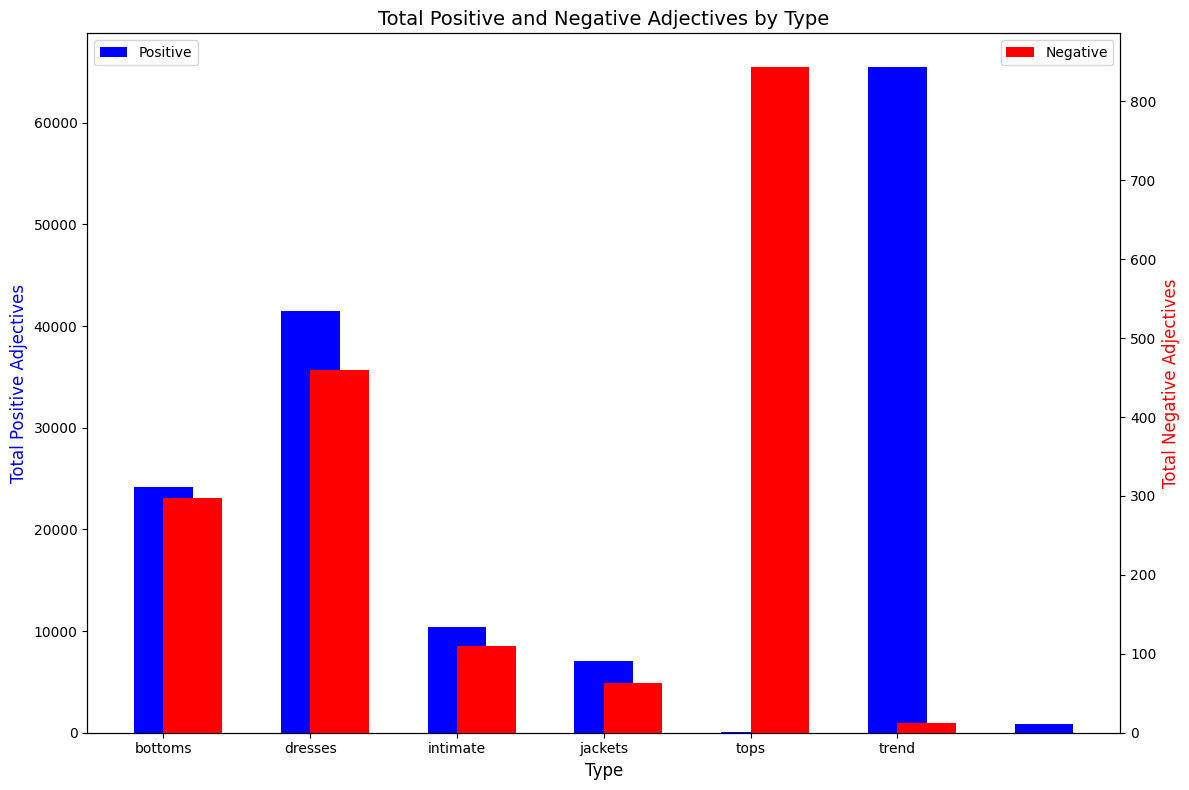

In [8]:
plot_adjective_counts(negative_adjectives_df, positive_adjectives_df)

## Analysis of Adjective Counts by Product Type

### Key Insights:
1. **Negative Reviews vs. Positive Reviews:**
    - Tops category stands out for having more negative adjectives than positive ones in comparison with other product categories.
    
2. **Positive Reviews Dominance:**
    - Conversely, the product type "trend" appears to receive more positive adjectives than negative ones.


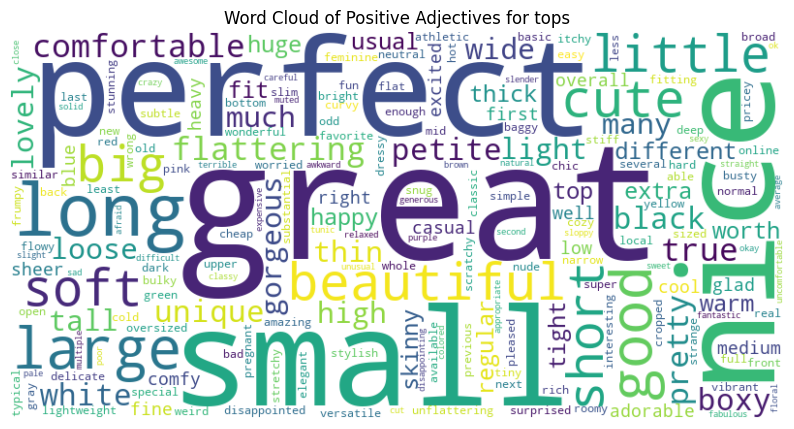

None

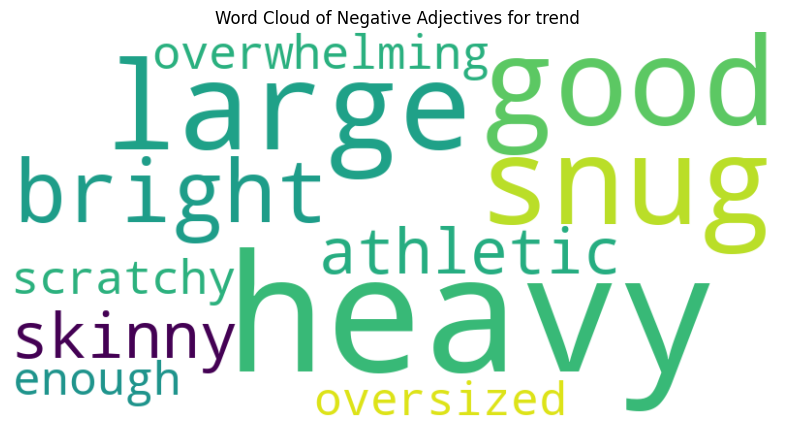

None

In [9]:
display(generate_wordcloud(positive_adjectives_df, positive=True, product_type='tops'))
display(generate_wordcloud(negative_adjectives_df, positive=False, product_type='trend'))


According to the analysis, some top adjectives for the "tops" category are:

- **Great**
- **Perfect**
- **Nice**

On the other hand, for the "trend" category, some top negative adjectives are:

- **Heavy**
- **Large**
- **Snug**


### Analysis

In [11]:
# Apply the function to the 'Text_Review' column
data['Text_Review_Sentiment'] = data['Text_Review'].apply(get_sentiment_score)


In [14]:
# Filter the DataFrame for 'tops' category and sort by sentiment score in ascending order (worst sentiment)
worst_tops_product_id = data[data['Type'] == 'tops'].sort_values(by='Text_Review_Sentiment')[['Product_ID', 'Text_Review_Sentiment']].head(1)

# Display the best product ID for 'trend' and worst product ID for 'tops' as pandas DataFrames
best_trend_product_id_df = pd.DataFrame(best_trend_product_id)
worst_tops_product_id_df = pd.DataFrame(worst_tops_product_id)

# Display the DataFrames
print("Best product ID for 'trend' category:")
display(best_trend_product_id_df)
print()

print("Worst product ID for 'tops' category:")
display(worst_tops_product_id_df)

Best product ID for 'trend' category:


,Product_ID,Text_Review_Sentiment
16238,568,0.9896



Worst product ID for 'tops' category:


,Product_ID,Text_Review_Sentiment
8783,866,-0.9532


In [16]:
# Filter the DataFrame for 'trend' category and sort by sentiment score in descending order
best_trend_product_id = data[data['Type'] == 'trend'].sort_values(by='Text_Review_Sentiment', ascending=False)[['Product_ID', 'Text_Review_Sentiment']].head(1)

# Filter the DataFrame for 'tops' category and sort by sentiment score in ascending order (worst sentiment)
worst_tops_product_id = data[data['Type'] == 'tops'].sort_values(by='Text_Review_Sentiment')[['Product_ID', 'Text_Review_Sentiment']].head(1)

# Display the best product ID for 'trend' and worst product ID for 'tops' as pandas DataFrames
best_trend_product_id_df = pd.DataFrame(best_trend_product_id)
worst_tops_product_id_df = pd.DataFrame(worst_tops_product_id)

# Display the DataFrames
print("Best product ID for 'trend' category:")
display(best_trend_product_id_df)
print()

print("Worst product ID for 'tops' category:")
display(worst_tops_product_id_df)

Best product ID for 'trend' category:


,Product_ID,Text_Review_Sentiment
16238,568,0.9896



Worst product ID for 'tops' category:


,Product_ID,Text_Review_Sentiment
8783,866,-0.9532


We find Product_ID 568 is the best reviewed product in 'trend' and  Product_ID 866 is the worst reviewed product in 'tops'.

### Implications:
- **Customer Sentiment Analysis:**
    - Products in the "tops" category may require closer attention to address potential areas of dissatisfaction highlighted by the prevalence of negative adjectives.
    - Conversely, leveraging the positive sentiment associated with "trend" products could be advantageous for marketing and product development strategies.

### Recommendations:
- **Actionable Steps:**
    - Conduct further analysis to uncover the specific attributes or features within the "tops" category that contribute to negative reviews. Addressing these pain points could lead to improved customer satisfaction. We shall look into the best reviewed product in 'trend', and worst reviewed product in 'tops'.
    - Capitalize on the positive sentiment surrounding "trend" products by incorporating their successful attributes into other product lines or marketing campaigns.
    - Implement sentiment monitoring tools to continuously track and respond to shifts in customer sentiment across different product categories.

- **Iterative Improvement:**
    - Regularly revisit and reassess the adjective distribution data to gauge the effectiveness of implemented strategies and initiatives.
    - Foster a culture of customer-centricity within the organization, prioritizing customer feedback and satisfaction as key drivers of business success.
